# Workflow Example: Copper-BOX Catalyst Library Construction

This notebook will show a full example of how you might use `molli` to generate a combinatorial catalyst library and extract features.

In [42]:
#Necessary imports
import molli as ml
ml.visual.configure(bgcolor='white')
import msgpack
import attrs

## Part 1: Parsing and Combinatorial Expansion

Here's how to do combinatorial expansion programmatically in Python. We will use an example BOX ligand from a CDXML file

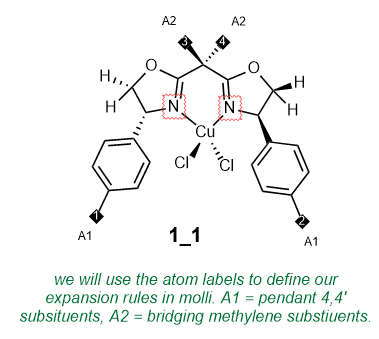

In [43]:
# first we read in our cores
cores = ml.CDXMLFile(ml.files.BOX_cores)

example_core = cores['1_1']
example_core

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Molecule(name='1_1', formula='C19 H4 Cl2 Cu1 N2 O2 Unknown4')

In [44]:
# Each core has 4 attachment points, 2 labelled A1 (the pendant 4,4' positions), and 2 labelled A2 (the bridging position).
attachment_points = [a for a in cores['1_1'].atoms if a.atype == ml.AtomType.AttachmentPoint]
attachment_points

[Atom(element=Unknown, isotope=None, label='A1', formal_charge=0, formal_spin=0),
 Atom(element=Unknown, isotope=None, label='A1', formal_charge=0, formal_spin=0),
 Atom(element=Unknown, isotope=None, label='A2', formal_charge=0, formal_spin=0),
 Atom(element=Unknown, isotope=None, label='A2', formal_charge=0, formal_spin=0)]

Next we will parse out the Bridging groups from the CDXML File, and join them at the bridge-head of the BOX ligand example core!

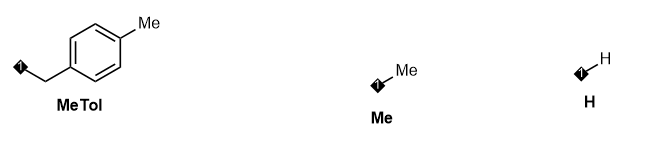

In [45]:
# now we will expand the bridging groups
bridging_groups = ml.CDXMLFile(ml.files.BOX_bridge)

# this will be our exapnded collection
cores_and_bridge_mols = []

# make a molecule for each core + bridging groups
for bridging_fragment in bridging_groups.keys():
    # get our bridge structure - molli assigns default 'AP1' label to attachment points without chemdraw-specified labels
    bridge_mol = bridging_groups[bridging_fragment]
    # join one bridging group fragment
    expanded = ml.Molecule.join(example_core, bridge_mol, 'A2', 'AP1')
    #join the other
    expanded = ml.Molecule.join(expanded, bridge_mol, 'A2', 'AP1', name = '_'.join([example_core.name, bridge_mol.name]))
    # add to our collection
    cores_and_bridge_mols.append(expanded)

print(f'There are now {len(cores_and_bridge_mols)} molecules created from the first example core.')

expanded

There are now 3 molecules created from the first example core.


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Molecule(name='1_1_Me', formula='C21 H4 Cl2 Cu1 N2 O2 Unknown2')

Now we will expand to a subset of the C4 substituents shown below:

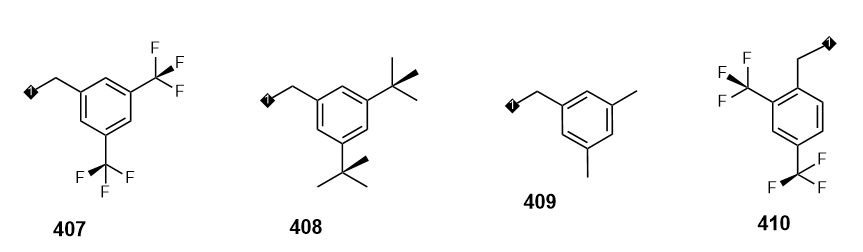

In [46]:
# now we will expand the bridging groups
four_positions = ml.CDXMLFile(ml.files.BOX_4_position)

c4_keys = ["407", "408", "409", "410"]

# this will be our exapnded collection
fully_expanded_mols = []

for core_and_bridge in cores_and_bridge_mols:

    # make a molecule for each core + bridging groups
    for pos4 in c4_keys:
        # get our 4-position fragment
        pos4_mol = four_positions[pos4]
        # join one 4-position group fragment
        expanded = ml.Molecule.join(core_and_bridge, pos4_mol, 'A1', 'AP1')
        #join the other
        expanded = ml.Molecule.join(expanded, pos4_mol, 'A1', 'AP1', name = '_'.join([ pos4_mol.name, core_and_bridge.name]))
        # add to our collection
        fully_expanded_mols.append(expanded)

print(f'There are now {len(fully_expanded_mols)} molecules created from the first example core.')

expanded

There are now 12 molecules created from the first example core.


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Molecule(name='410_1_1_Me', formula='C39 H4 Cl2 Cu1 F12 N2 O2')

## Part 2: Adding Hydrogens and Optimization

`CDXML` does not natively parse hydrogens, although `molli` has the ability to read these directly.

In [47]:
# finally, we'll do an optimization with XTB gfn2 to clean up our geometries a bit

for mol in fully_expanded_mols:
    mol.add_implicit_hydrogens()

mol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Molecule(name='410_1_1_Me', formula='C39 H30 Cl2 Cu1 F12 N2 O2')

### Example 1: Parallel Openbabel Optimization 

Example of optimization using the built in functionality with `openbabel` optimization

In [54]:
from joblib import delayed, Parallel
from molli.external import openbabel as mob

# Sets up and runs parallel calculation using Openbabel
res = Parallel(n_jobs=32, verbose=50,prefer='threads')(
delayed(mob.obabel_optimize)(
    mol= mol, 
    ff="gaff",
    coord_displace=True
    ) for mol in fully_expanded_mols)

res[1]

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=32)]: Done   2 out of  12 | elapsed:    1.8s remaining:    9.1s
[Parallel(n_jobs=32)]: Done   3 out of  12 | elapsed:    2.7s remaining:    8.1s
[Parallel(n_jobs=32)]: Done   4 out of  12 | elapsed:    3.7s remaining:    7.4s
[Parallel(n_jobs=32)]: Done   5 out of  12 | elapsed:    4.6s remaining:    6.5s
[Parallel(n_jobs=32)]: Done   6 out of  12 | elapsed:    5.6s remaining:    5.6s
[Parallel(n_jobs=32)]: Done   7 out of  12 | elapsed:    7.1s remaining:    5.1s
[Parallel(n_jobs=32)]: Done   8 out of  12 | elapsed:    9.9s remaining:    5.0s
[Parallel(n_jobs=32)]: Done   9 out of  12 | elapsed:    9.9s remaining:    3.3s
[Parallel(n_jobs=32)]: Done  10 out of  12 | elapsed:   11.4s remaining:    2.3s
[Parallel(n_jobs=32)]: Done  12 out of  12 | elapsed:   15.2s finished


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Molecule(name='408_1_1_MeTol', formula='C65 H78 Cl2 Cu1 N2 O2')

## Example 2: XTB Optimization via Job Mapping

One can also take advantage of the jobmap functionality to run this optimization

```python
from molli.pipeline.xtb import XTBDriver

#Serializes the molecule library as is
source = ml.MoleculeLibrary('box_unoptimized.mlib', readonly=False)
with source.writing():
    for mol in fully_expanded_mols:
        source[mol.name] = mol

#This is the file the conformer ensembles calculated will be written to.
destination = ml.MoleculeLibrary("box_optimized.mlib", readonly=False)

#This configures the driver, number of processes to use for each worker. Can also indicate how much memory to use.
xtb = XTBDriver(nprocs=4)

ml.pipeline.jobmap(
    xtb.optimize_m,
    source=source, #Source of molecules
    destination=destination, #Where conformers will be written
    cache_dir="./conf_cache", #Where final outputs will be written, successful or not!
    scratch_dir="/scratch/user/", #Scratch Directory where calculations will be run
    n_workers=4, #Number of workers to use. In this case, 4 workers, each with 16 processors as defined in the driver.
    kwargs={
        "method": "gfnff", #GFNFF method to be used
    }, #These are arguments used in the xtb job
    progress=True, #Will print out progress
    verbose = True, #Will print out extra information
)
```